In [1]:
'''Bridget Mohler
NLP Assignment 1
Sentiment Analysis Text Classifier
28 September 2022'''
#Importing all the packages used
import numpy as np
import pandas as pd
import re
import sklearn
import random
import seaborn as sns
from sklearn.utils import resample
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
from unittest import skip

[nltk_data] Downloading package punkt to /Users/bridget/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv("movie_reviews.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [3]:
df.head()  # print head of data frame with help of head function

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


In [4]:
#print the headers for the columns to prepare for plotting the positive vs. negative reviews
for col in df.columns:
    print(col)

review
sentiment


In [5]:
#this breaks up the dataframe into separate dfs for positive and negative
#the print statements are used to take a look at the total number of positive vs. negative reviews in the "sentiment" column
pos = df[df['sentiment'] == "positive"]
neg = df[df['sentiment'] == "negative"]
print(len(pos))
print(len(neg))

12474
12225


/Users/bridget/opt/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


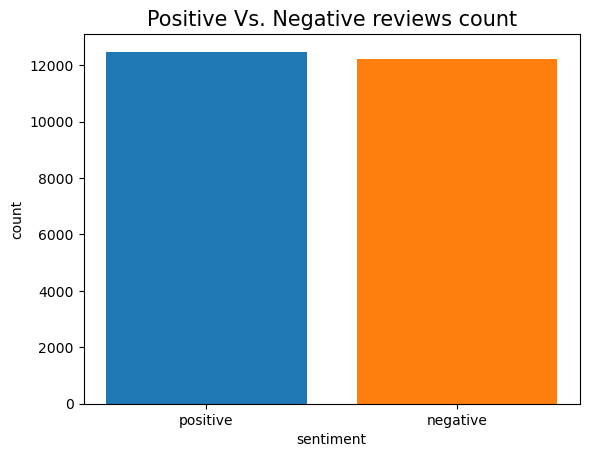

In [6]:
#plotting the comparison of positive vs. negative reviews
plt.figure(figsize = None)
sns.countplot(None)
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
sentiments = ['positive', 'negative']
values = [len(pos), len(neg)]
plt.xticks([0, 1], ['positive', 'negative'])
plt.xlabel("sentiment")
plt.bar(sentiments, values, color = ["tab:blue", "tab:orange"])
plt.show()

In [7]:
#assigning the review dataframes to the minority and majority class based on which there are more of, upsampling to account for this discrepancy
df_majority = pos
df_minority = neg

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([pos, negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)

In [8]:
#check the initial shape of the majority (positive reviews)
df_majority.shape

(12474, 2)

In [9]:
#check the initial shape of the minority (negative reviews)
df_minority.shape

(12225, 2)

In [10]:
#check that the negative reviews have been correctly upsampled to match the shape of the majority positive reviews
negative_upsample.shape

(12474, 2)

In [11]:
#check that the concatenated df_upsampled is equal in length to df_majority + negative_upsample
len(df_upsampled) == len((df_majority + negative_upsample))
#this returns true so we seem to be all set to proceed

True

In [12]:
#looking at the head of the upsampled dataframe to make sure everything is as it should be
df_upsampled.head()

,review,sentiment
21384,"These days, you rarely come by a kid's show th...",positive
10463,"The film ""52 Pick Up"" simply does not work. Se...",negative
22043,"Its a spoof, its an intelligent comedy, it has...",positive
10291,Bad Movie! Bad! Go stand in a discount bin. Ca...,negative
23633,I'd never heard of this Aussie horror prior to...,positive


In [13]:
## In this cell, we are going to be dividing the data into train and test points

## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled["sentiment"]=="positive"].iloc[:10000]
positive_data_points_train = df_upsampled[df_upsampled["sentiment"]=="negative"].iloc[:10000]

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled["sentiment"]=="positive"].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled["sentiment"]=="negative"].iloc[10000:]

## Concatenate the training positive and negative reviews
X_train = pd.concat([negative_data_points_train["review"], positive_data_points_train["review"]])
## Concatenating the training positive and negative outputs
y_train = pd.concat([negative_data_points_train["sentiment"], positive_data_points_train["sentiment"]])

## Concatenating the test positive and negative reviews
X_test = pd.concat([negative_data_points_test["review"], positive_data_points_test["review"]])
## Concatenating the test positive and negative outputs
y_test = pd.concat([negative_data_points_test["sentiment"], positive_data_points_test["sentiment"]])

In [14]:
#making sure there are the correct number of positive and negative reviews (10000 of each) 
y_train.value_counts()

positive    10000
negative    10000
Name: sentiment, dtype: int64

In [15]:
#making sure there are the correct number of positive and negative reviews (2474 of each)
y_test.value_counts()

positive    2474
negative    2474
Name: sentiment, dtype: int64

In [16]:
## Q1. Pre-Processing the Reviews

In [17]:
'''Function: clean_review
Parameters: review (the review to be cleaned)
Output: the review once it has been stripped of websites, line break markers, email addresses, punctuation and stopwords, as well as being tokenized and those tokens stemmed,
the ultimate format will be a list of tokens'''

def clean_review(review):
    review = review.lower() #changes all capital letters to lower case
    review = re.sub(r"<br ?/>", " ", review) # removes <br>s
    review = re.sub(r"http\S+", " ", review) # replaces URLs starting with http 
    review = re.sub(r"www.\S+", " ", review) # replaces URLs starting with www
    review = re.sub(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", "",review) # replaces email addresses
    review = re.sub(r'[\'!@#?()*+_::<=>[\]^~{|}~"&,.-]', ' ', review) #removes the majority of punctuation outright
    review = re.sub(r'\/[^0-9/0-9]', ' ', review) #removes slashes unless directly preceding digits (to preserve fractions, like 4/10 stars)
    stopword = nltk.corpus.stopwords.words('english') #defines stopwords
    review = " ".join([word for word in re.split(' ', review) #removes those stopwords (modified to remove at a break ' ' insted of a word /W+ to allow for the retention of ' as explained above)
            if word not in stopword])
    review = word_tokenize(review)
    stemmer = PorterStemmer()
    review_cleaned = [stemmer.stem(word) for word in review]
    return review_cleaned

#testing on a randomly selected review from the training dataset by printing the initial review as well as the cleaned result
test_review = X_train.iloc[10403]
print(test_review)
clean_review(test_review)


Raising victor Vargas is just a bad film. No amount of denial or ad-dollar supported publicity with change this sad fact.<br /><br />Maybe Peter Sollett saw he didn't have the money to do the movie he wanted to make and decided to take the easy way out by making a bad film that cynically apes the tenets of current "edgy film-making". Maybe he just doesn't know any better. It's hard to tell.<br /><br />What's not hard to tell is the result. Except for a few viewers who will intellectualize the bad film-making into an attempt at pseudo-realism, few will enjoy it.<br /><br />I know I didn't.<br /><br />Do yourselves a favor and pass on this film.


['rais',
 'victor',
 'varga',
 'bad',
 'film',
 'amount',
 'denial',
 'ad',
 'dollar',
 'support',
 'public',
 'chang',
 'sad',
 'fact',
 'mayb',
 'peter',
 'sollett',
 'saw',
 'money',
 'movi',
 'want',
 'make',
 'decid',
 'take',
 'easi',
 'way',
 'make',
 'bad',
 'film',
 'cynic',
 'ape',
 'tenet',
 'current',
 'edgi',
 'film',
 'make',
 'mayb',
 'know',
 'better',
 'hard',
 'tell',
 'hard',
 'tell',
 'result',
 'except',
 'viewer',
 'intellectu',
 'bad',
 'film',
 'make',
 'attempt',
 'pseudo',
 'realism',
 'enjoy',
 'know',
 'favor',
 'pass',
 'film']

In [18]:
'''Function: find_occurrence
Parameters: frequency - a frequency dictionary of the words in the vocab for the reviews 
            word - the word we're trying to find the number of occurrences for
            label - 0 or 1 depending on whether we want the positive or negative occurrences of the word
The word and label make up the key for the frequency dict
Outputs: the number of times the word occurs in the context of its given label
This will be the value associated with the word,label key in the dictionary'''

def find_occurrence(frequency, word, label):
    if (word,label) not in frequency:
        result = 0
    else:
        result = frequency[word,label]
    return result


In [19]:
#Up to this point we've used string labels of "positive" and "negative" but now we use mapping to convert those strings to the integers 0 and 1 respectively

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [20]:
# Ensuring that there are equal number of classes on the training data. 
y_train.value_counts()

0    10000
1    10000
Name: sentiment, dtype: int64

In [21]:
# Choosing a random review and taking a look at it.
X_train.iloc[0]

"These days, you rarely come by a kid's show that does not involve 1) a preteen/teen pop star who is as amusing as watching paint dry 2) involve a plot about finding the perfect date with a different guy/girl every time 3) revolves around erratic yelling and unintelligible humor. About 95% of shows on Disney, Nickelodeon, and Cartoon Network fit the listed criteria. To put in simpler terms, they all lack good acting, originality, and good story telling. It as if producers and writers think kids aren't smart enough to understand character development and plot detail. They couldn't be more unaware. Sure kids enjoy a good laugh and erratic behavior (if it's done to a conservative level and done right), but as they also want to enjoy a story, see drama, and see people being challenged. They don't want to see people living in a flawless world where they get everything they want. They know this world isn't all fun and games, they know it's not perfect. Everyone has problems, and we all must 

In [22]:
custom_review = X_train.iloc[0]

# print cleaned review
print(clean_review(custom_review))

['day', 'rare', 'come', 'kid', 'show', 'involv', '1', 'preteen', 'een', 'pop', 'star', 'amus', 'watch', 'paint', 'dri', '2', 'involv', 'plot', 'find', 'perfect', 'date', 'differ', 'guy', 'irl', 'everi', 'time', '3', 'revolv', 'around', 'errat', 'yell', 'unintellig', 'humor', '95', '%', 'show', 'disney', 'nickelodeon', 'cartoon', 'network', 'fit', 'list', 'criteria', 'put', 'simpler', 'term', 'lack', 'good', 'act', 'origin', 'good', 'stori', 'tell', 'produc', 'writer', 'think', 'kid', 'smart', 'enough', 'understand', 'charact', 'develop', 'plot', 'detail', 'unawar', 'sure', 'kid', 'enjoy', 'good', 'laugh', 'errat', 'behavior', 'done', 'conserv', 'level', 'done', 'right', 'also', 'want', 'enjoy', 'stori', 'see', 'drama', 'see', 'peopl', 'challeng', 'want', 'see', 'peopl', 'live', 'flawless', 'world', 'get', 'everyth', 'want', 'know', 'world', 'fun', 'game', 'know', 'perfect', 'everyon', 'problem', 'must', 'learn', 'work', 'around', 'show', 'revolv', 'around', 'kind', 'stuff', 'alex', 'ma

## Q3. Implementing Review Counter Function

In [23]:
'''Function: review_counter
Parameters: output_occurrence - an empty dictionary to which each word label pair will be mapped to its frequency
            reviews - a list of reviews
            positive_or_negative - a list of the sentiments (positive or negative) assigned to each review
Outputs: a dictionary where the keys are word label pairs (where the label is the sentiment) and the values are the frequencies of those pairs
'''

def review_counter(output_occurrence, reviews, positive_or_negative):

    for label, review in zip(positive_or_negative, reviews):
        for token in clean_review(review):
            key = (token,label)
            if key in output_occurrence:
                output_occurrence[key] += 1
            else:
                output_occurrence.update({key:1})
   
    return output_occurrence



In [24]:
#testing the review_counter
result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result,reviews, ys)

{('got', 1): 1,
 ('bore', 1): 2,
 ('throught', 1): 1,
 ('moview', 1): 1,
 ('movi', 0): 2,
 ('fantast', 0): 1,
 ('watch', 1): 1,
 ('complet', 1): 1,
 ('wast', 1): 1,
 ('time', 1): 1,
 ('money', 1): 1,
 ('enjoy', 0): 1,
 ('fullest', 0): 1}

In [25]:
# Build the freqs dictionary for later uses
# freqs will be the frequency dictionary for all the words and their corresponding labels in our training data
freqs = review_counter({}, X_train, y_train)

In [26]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels. 
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequence of occurence of word given that a review is 'negative'.
freqs

{('day', 0): 1802,
 ('rare', 0): 398,
 ('come', 0): 2713,
 ('kid', 0): 1172,
 ('show', 0): 4478,
 ('involv', 0): 804,
 ('1', 0): 448,
 ('preteen', 0): 4,
 ('een', 0): 3,
 ('pop', 0): 200,
 ('star', 0): 1766,
 ('amus', 0): 258,
 ('watch', 0): 5196,
 ('paint', 0): 195,
 ('dri', 0): 79,
 ('2', 0): 717,
 ('plot', 0): 2052,
 ('find', 0): 2365,
 ('perfect', 0): 1085,
 ('date', 0): 404,
 ('differ', 0): 1465,
 ('guy', 0): 1412,
 ('irl', 0): 7,
 ('everi', 0): 1614,
 ('time', 0): 6650,
 ('3', 0): 508,
 ('revolv', 0): 113,
 ('around', 0): 1328,
 ('errat', 0): 7,
 ('yell', 0): 50,
 ('unintellig', 0): 6,
 ('humor', 0): 703,
 ('95', 0): 25,
 ('%', 0): 155,
 ('disney', 0): 313,
 ('nickelodeon', 0): 7,
 ('cartoon', 0): 338,
 ('network', 0): 119,
 ('fit', 0): 411,
 ('list', 0): 264,
 ('criteria', 0): 9,
 ('put', 0): 1249,
 ('simpler', 0): 23,
 ('term', 0): 286,
 ('lack', 0): 511,
 ('good', 0): 6083,
 ('act', 0): 2806,
 ('origin', 0): 1305,
 ('stori', 0): 5647,
 ('tell', 0): 1308,
 ('produc', 0): 644,
 

In [27]:
#testing the find_occurrence function with the freqs dictionary as an argument
find_occurrence(freqs,"great",1)
find_occurrence(freqs,"great",0)

5132

## Q4. Training the Naive Bayes Model

In [28]:
#creating a vocab of all the words in the frequency dictionary 
#(disregarding sentiment labels so if a word occurs in both a positive and negative context it is only counted once)

#checking how many word,label pairs are in the freqs dict
print(len(freqs))
#building the vocab
vocab = set(pair[0] for pair in freqs.keys())
V = len(vocab)
#checking how many words are in the vocab (it should be significantly fewer than in freqs, but not outrageously different)
#dropping by about 1/3 is ok, but if dropping by 1/2 something is probably wrong
print(V)

66500
46446


In [29]:
'''Function: train_naive_bayes
Parameters: freqs - dictionary where keys are word,label pairs and values are the corresponding number of occurrences
            train_x - a list of reviews
            train_y - a list of labels (0 for positive, 1 for negative) corresponding to those reviews
Outputs: logprior: the log prior (logarithmic form for the Naive Bayesian prior)
        loglikelihood: the log likelihood (logarithmic form for the Naive Bayesian likelihood
Both are probabilities, that will be used to help predict which sentiment a review should be classified as'''

def train_naive_bayes(freqs, train_x, train_y):

    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = set(pair[0] for pair in freqs.keys())
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1]<1:

            # Increment the number of positive words by the count for this (word, label) pair
            num_pos += freqs[(pair)]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            num_neg += freqs[(pair)]

    # Calculate num_doc, the number of documents
    num_doc = len(y_train)

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = train_y.value_counts()[0]

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = train_y.value_counts()[1]

    # Calculate logprior
    logprior = np.log(pos_num_docs)-np.log(neg_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs, word, 0)
        freq_neg = find_occurrence(freqs, word, 1)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (num_pos + V)
        p_w_neg = (freq_neg + 1) / (num_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)


    return logprior, loglikelihood

In [30]:
#JUST FOR GRADER
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))


0.0
46446


In [31]:
#This is not relevant to the running of the sentiment analysis in this notebook
#It creates a csv file of the loglikelihoods for each word to be used in the python file as an additional part of this project (see text_classifier.py)
words = list(loglikelihood.keys())
likelihoods = list(loglikelihood.values())
df = pd.DataFrame(words, columns=['Words'])
df["Likelihoods"] = likelihoods
df.to_csv("model_params.csv")

## Q5. Implementing Naive Bayes Predict Function

In [32]:
'''Function: naive_bayes_predict
Parameters: review - a string (of a review)
        logprior - a probability
        loglikelihood - a dictionary of words mapping to probabilities
Outputs: total_prob - the sum of all the likelihoods of each word in the review (if the word is present in the loglikelihood dict) added to logprior'''
def naive_bayes_predict(review, logprior, loglikelihood):
    
      # process the review to get a list of words
    word_l = clean_review(review)

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob += logprior
    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            total_prob += loglikelihood[word]
            #print("new total_prob is:",total_prob, "word was:", word)
    if total_prob > 0:
        total_prob = 0
    else:
        total_prob = 1
    return total_prob


In [33]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


## Q6. Implementing Naive Bayes Test function

In [34]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
'''Function: test_naive_bayes
Parameters: test_x - a list of reviews
            test_y - the corresponding labels for the list of reviews
            logprior - the logprior
            loglikelihood - a dictionary of the loglikelihoods for each word
Outputs: accuracy - the number of reviews classified correctly divided by the total number of reviews'''
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):

    accuracy = 0  

    y_hats = []
    for review in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(review, logprior, loglikelihood) > 0:
            y_hat_i  = 1

        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error_rate = np.mean(np.absolute([a-b for a, b in zip(y_hats, test_y)]))
    num_errors = (len(test_x))*error_rate

    #accuracy = (len(test_x))
    accuracy = (len(test_x)-num_errors)/len(test_x)

    #providing printed feedback on the results
    print("error is:",error_rate)
    print("number of errors is:", num_errors)
    print("number of reviews:",len(test_x))
    print("accuracy",accuracy)
    return accuracy

In [35]:
test_naive_bayes(X_train, y_train, logprior, loglikelihood)

error is: 0.07875
number of errors is: 1575.0
number of reviews: 20000
accuracy 0.92125


0.92125

In [36]:
test_naive_bayes(X_test, y_test, logprior, loglikelihood)

error is: 0.12126111560226355
number of errors is: 600.0
number of reviews: 4948
accuracy 0.8787388843977365


0.8787388843977365

In [37]:
# For grading purpose only
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


In [38]:
# Feel free to check the sentiment of your own review below
my_review = 'The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

# Q7. Evaluate the accuracy

In [39]:
'''Function: split_data
Parameters: seed - a randomizing seed to allow the data to be randomized in the same way repeatedly
Outputs: split_data.random_X_test - randomized test data consisting of reviews
        split_data.random_X_train - randomized train data consisting of reviews
        split_data.random_y_test - randomized test data consisting of sentiment labels that correspond to the reviews in random_X_test
        split_data.random_y_train - randomized train data consisting of sentiment labels that correspond to the reviews in random_y_test'''

def split_data(seed):
    #setting data up to be randomized (need to be lists for random shuffle)
    X = df_upsampled["review"]
    X = X.tolist()
    y = df_upsampled['sentiment']
    y = y.map(output_map)
    y = y.tolist()

    #randomizing the data
    random.Random(seed).shuffle(X)
    random.Random(seed).shuffle(y)

    #splitting the data so 1/4 of it goes to test and 3/4 to train
    #reorganizing the data as series instead of lists
    split_data.random_X_test = X[:len(X)//4]
    split_data.random_X_test = pd.Series(split_data.random_X_test)
    split_data.random_y_test = y[:len(y)//4]
    split_data.random_y_test = pd.Series(split_data.random_y_test)
    split_data.random_X_train = X[len(X)//4:]
    split_data.random_X_train = pd.Series(split_data.random_X_train)
    split_data.random_y_train = y[len(X)//4:]
    split_data.random_y_train = pd.Series(split_data.random_y_train)

    return split_data.random_X_test, split_data.random_X_train, split_data.random_y_test, split_data.random_y_train
split_data(5)

(0       The best martial arts movie ever made. This on...
 1       How is it possible that a movie this bad can b...
 2       I must admit, at first I wasn't expecting anyt...
 3       My god this movie is awfully boring. I am a bi...
 4       I was extraordinarily impressed by this film. ...
                               ...                        
 6232    When I fist watched the movie, I said to mysel...
 6233    Dick and Jane Harper (Jim Carrey, TÃ©a Leoni) ...
 6234    Although Kris Kristofferson is good in this ro...
 6235    Cult purchasers are unquestionably familiar wi...
 6236    One of the worst movies I've ever seen with Ro...
 Length: 6237, dtype: object,
 0        I've been working my way through a collection ...
 1        I have read the novel Reaper of Ben Mezrich a ...
 2        This place in England during 1940. Three orpha...
 3        Maybe the subject was good, but put down to a ...
 4        o m g!!! did you ever think they would make a ...
                     

In [40]:
#split_data. was required for accessing these outside of the function but gets cumbersome so renamed
random_X_train = split_data.random_X_train
random_y_train = split_data.random_y_train
random_X_test = split_data.random_X_test
random_y_test = split_data.random_y_test

In [41]:
#taking a look to make sure nothing has gone weird
random_freqs = review_counter({}, random_X_train, random_y_train)
checking_keys = list(random_freqs.keys())[0]
logprior,loglikelihood = train_naive_bayes(random_freqs, random_X_train, random_y_train)
print(len(random_freqs))
print(logprior)
print(len(loglikelihood))

64846
-0.0011757790890118969
45301


In [42]:
#taking a look at accuracy for newly randomized data
test_naive_bayes(random_X_train, random_y_train, logprior, loglikelihood)

error is: 0.07754796643685533
number of errors is: 1451.0
number of reviews: 18711
accuracy 0.9224520335631446


0.9224520335631446

In [43]:
test_naive_bayes(random_X_test, random_y_test, logprior, loglikelihood)

error is: 0.1282667949334616
number of errors is: 800.0
number of reviews: 6237
accuracy 0.8717332050665384


0.8717332050665384

In [44]:
#renaming random_y_test for clarity's sake (random_y_test is the accurate list of sentiment labels)
actual_results = random_y_test

#sorting into two lists, one for the true positives, one for true negatives
actual_pos = actual_results.tolist().count(0)
actual_neg = actual_results.tolist().count(1)

#empty list for the predicted labels
predicted_results = []

#for each review in random_X_test calculate the predicted sentiment and add to the predicted_results list
for review in random_X_test:
    prediction = naive_bayes_predict(review, logprior, loglikelihood)
    predicted_results.append(prediction)

#empty lists for indices of the false positives, false negatives, true positives and true negatives 

false_neg_index = []
false_pos_index = []
true_pos_index = []
true_neg_index = []

#set initial index to -1 so when we add 1 to each index as the first part of our loop we actually start with 0 as we want
index = -1
#for the corresponding values in actual results and predicted results
#if the actual result is positive and the prediction is negative add the index to false_neg_index
#if the actual result is negative and the prediction is positive add the index to false_pos_index
#if the actual result is positive and the prediction is positive add the index to true_pos_index
#if the actual result is negative and the prediction is negative add the index to true_neg_index
#increase the index and repeat until done
for a, b in zip(actual_results, predicted_results):
    index += 1
    if a==0 and b==1:   
        false_neg_index.append(index)
    elif a==1 and b==0:
        false_pos_index.append(index)
    elif a==0 and b==0:
        true_pos_index.append(index)
    elif a==1 and b==1:
        true_neg_index.append(index)

#empty lists for the actual false negative and false positive reviews 
#(prior to being cleanned so they can be read and interpreted on a human level for context to better understand why they were misclassified)
false_neg_reviews_unclean =[]
false_pos_reviews_unclean =[]

#empty lists for the false negative reviews, false positive reviews, true negative reviews, and true positive reviews
#(after being cleaned so each review will be a tokenized list)
false_neg_reviews = []
false_pos_reviews = []
true_neg_reviews = []
true_pos_reviews = []

#using each index add the corresponding review to the appropriate reviews list
#false predictions are added both in cleaned form to _reviews and uncleaned form _reviews_unclean
#I want to actually be able to read the unaltered false reviews to get a sense of where the ambiguity is that led to them being misclassified
#with the correctly classified reviews there is no need
for index in false_neg_index:
    false_neg_reviews_unclean.append(split_data.random_X_test[index])
    false_neg_reviews.append(clean_review(split_data.random_X_test[index]))
for index in false_pos_index:
    false_pos_reviews_unclean.append(split_data.random_X_test[index])
    false_pos_reviews.append(clean_review(split_data.random_X_test[index]))
for index in true_neg_index:
    true_neg_reviews.append(clean_review(split_data.random_X_test[index]))
for index in true_pos_index:
    true_pos_reviews.append(clean_review(split_data.random_X_test[index]))

#the number of false positive and false negatives
num_false_neg = len(false_neg_reviews)
num_false_pos = len(false_pos_reviews)

#the rate of false positives and false negatives
rate_false_neg = num_false_neg/len(random_X_test)
rate_false_pos = num_false_pos/len(random_X_test)

#the percent of false positives and false negatives in relation to the total
percent_false_neg = round((rate_false_neg * 100),2)
percent_false_pos = round((rate_false_pos * 100),2)

#the number of true negatives and true positives
num_true_neg = actual_neg-len(false_neg_reviews)
num_true_pos = actual_pos-len(false_pos_reviews)

#the rate of true negatives and true positives
rate_true_neg = num_true_neg/len(random_X_test)
rate_true_pos = num_true_pos/len(random_X_test)

#the percent of true negatives and true positives in relation to the total
percent_true_neg = round((rate_true_neg * 100),2)
percent_true_pos = round((rate_true_pos * 100),2)


[[0.42680776 0.05595639]
 [0.07231041 0.44492544]]


Text(50.722222222222214, 0.5, 'Actual Values')

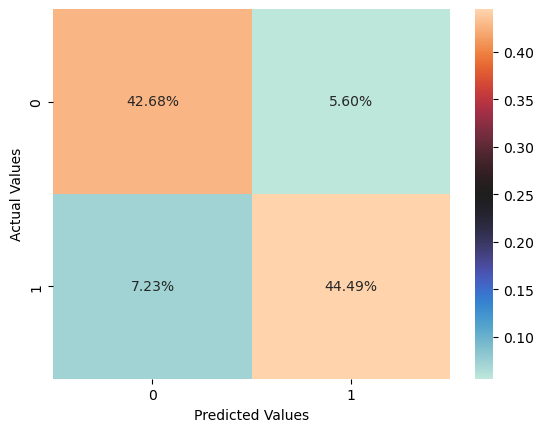

In [45]:
#creating a visualization of the confusion matrix using seaborn
matrix_array = np.array([[rate_true_neg, rate_false_pos], [rate_false_neg, rate_true_pos]])
#printing the basic array
print(matrix_array)
#classing it up a bit
cm = sns.heatmap(matrix_array, cmap="icefire", fmt=".2%", annot=True)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

## Q7. Reason for Misclassification Discussion:
Having printed a list of tokens that appear in false negatives and false positives and sorted those tokens by how often they occur, some patterns begin to emerge that could contribute to the inaccurate prediction. First, for both the false negative reviews and the false positive reviews, the four most common words (though the ordering among these four differs between false positives and false negatives) are (with the stemming ignored for clarity), "movie", "film", "one", and "like". Since these words appear commonly across postive and negative reviews and none of them carry a particularly heavy weight as being either positive or negative ("movie" has a logprior value of -0.274537885142484, "film" has 0.108335405549288, "one" has 0.0220387487129296, and "like" has -0.197440371967943) these most common words aren't especially helpful for providing a definitive classification. Looking at a smattering of the actual falsely classified reviews, to get a more in depth sense of what is actually happenig contextually. For example, some of the false positives spent a great deal of time talking about positive things that were lacking from the movie in question (be that comparing it to other, better movies, talking about things they wanted the movie to do or ways it could have been improved, etc.) and all of those positive words were being counted towards a prediction of positive even though they weren't actually being used in reference to the movie being reviewed. As an example of one such false positive review:

"Sometimes laughter in the middle of a horror film is a signal of its greatness. I remember the nervous laughter from the audience in the re-release of The ExcorcistÂ really nervous laughter. It punctuated just how freaked out we all were watching the voice of Satan coming out of a 12 year old girl. In the case of the 2006 remake of the 1972 cult classic The Wicker Man however, it made me think that this new Wickerman is about as scary as the South Park character, Scuzzlebut, the friendly forest monster with TV's Patrick Duffy for a leg and a celery stalk for an arm who's favorite hobby is weaving wicker baskets. 3 years ago a friend of mine in Hollywood told me that he heard that Nicolas Cage was going to do a remake of the film. I started laughing and my friend (Keith) got mad at me touting Nicolas Cage as a great actor. I just didn't think that he could pull it off and unfortunately for moviegoers I was right. Gone is the realness, the outstanding original music, the originality, the creepiness and the wonderfully powerful dialogue. Instead we have horror movie cliches, affected acting and changes to the storyline that make any believability fall apart. Like many of the countless Hollywood remakes we have been inundated with lately this feels like we are watching 4th graders on a playground "playing Wickerman". The original film takes place on a remote Scottish Isle where a Scottish police officer is lured there to find a missing young girl named Rowan Morrison. In the new spin a California cop (Cage) is lured to an island of the coast of Washington state by his ex-girlfriend to find her missing daughter. She sends a photo and the missing daughter looks exactly like a young girl he tried to save in a fiery crash not long ago. The crash still haunts him in part because the girl's body was never found. Yet even after he gets a letter with her picture in it that connection is completely cast aside as he heads north, alone, to help his ex-girlfriend find her daughter. He arrives to find an island full of actors pretending to be the descendants of Wiccans, many of whom seem like they didn't get call backs for roles in The Village. And like The Village it isn't long before you realize there is nothing to be afraid of here. Not even the cloudy eyed blind sisters who speak in unison. I think that the opportunity in Hollywood to make great amounts of money on a film often comes at great expense to the artistry. I think someone like Nicolas Cage who is in so many films these days loses touch with the magic that film can be when it gets to the point where he has a personal chef on the set preparing his snacks. We needed a bad re-make of the Wickerman like we needed yet another '9-11' movie. I'm starting to wonder if Nicolas changed his surname from Coppola because he wanted to or because he was pleaded with to do so."

Above is the review in its uncleaned form, but even once it had been stemmed, stripped of punctuation and excess words, etc. for prediction purposes, positives like "greatness" (0.813614590909551 once stemmed to "great"), "classic" (0.645512802257026), "outstanding" (1.58236075640738, stemmed to "outstand"), "wonderfully" (0.576647762959286, stemmed to "wonder"), etc. would still remain (albeit in stemmed forms) even though all of these positive words are actually being used as comparisons to describe how negative the movie is. 

Another potential factor in false classifications seems to be genre, with a cursory overview of the reviews themselves seeming to include a disproportionate number of horror movies (though given the lack of genre data included with the initial dataset, it is hard to be definitive about this). Consider for example the following false negative, which is illustrative of a number of others found in that category (again, before being cleaned):

"I caught this movie on the Sci-Fi channel recently. It actually turned out to be pretty decent as far as B-list horror/suspense films go. Two guys (one naive and one loud mouthed a**) take a road trip to stop a wedding but have the worst possible luck when a maniac in a freaky, make-shift tank/truck hybrid decides to play cat-and-mouse with them. Things are further complicated when they pick up a ridiculously whorish hitchhiker. What makes this film unique is that the combination of comedy and terror actually work in this movie, unlike so many others. The two guys are likable enough and there are some good chase/suspense scenes. Nice pacing and comic timing make this movie more than passable for the horror/slasher buff. Definitely worth checking out."

The viewer clearly enjoyed the movie but is honest about having done so more as a bit of stupid fun than a work of cinematic art, and it is easy to see how, even though the review is ultimately positive, terms like "B-list" (-0.521459736246108 stemmed to "b", and -0.242829497318239, stemmed to "list"), "worst" (-2.36141396089183), "maniac" (-0.522377931886275), "freaky" (-0.425783765300653, stemmed to "freak"), etc. slide it into being falsely classified as negative even though within the context of the review they are actually being used pretty positively. 

Another problem seems to be the ambiguity of the initial classification. Some of the reviews are lukewarm and arguably could be classified as either positive, negative, or (perhaps more accurately), neither. Take for example:

"Simon Wests pg-13 thriller about a babysitter who gets disturbing prank calls while sitting at a mansion is neither original nor exciting enough to be called a good film. Although there are some elements of suspense, good eye candy and decent characters, the film is just another I know what you did last summer, as it falls short of being taken seriously. The performances were alright, but nothing special with this flick, i say skip it, unless you are looking for a mediocre movie, you can find better films than this on lifetime sometimes, okay maybe not lifetime but at least USA or somethin, haha....7/10"

This review is ultimately classified as positive in the original dataset and the 7/10 rating is, empirically, positive, but the words leading up to that final numeric rating are very lackluster meaning, while this is technically a false negative, it is difficult to equivocally call it a positive review even when that is how it is oficially classified. 

While these are specific examples based on a cursory (and decidedly human) overview of the data they speak to the subjectivity of language and suggest areas where the current programming is falling short and ways in which it might potentially be improved in future. 

Returning briefly to empirical CS for a moment, I wanted to check whether the length of a review had any relation to the likelihood of it being incorrectly classified, but a comparison of the range of lengths (in number of tokens) and average length for reviews in a given category yielded the following results:

False Neg Max: 622
False Neg Min: 16
False Neg Avg: 106.36605316973416

False Pos Max: 533
False Pos Min: 6
False Pos Avg: 134.57692307692307

True Neg Max: 556
True Neg Min:6
Ture Neg Avg: 116.99605451936873

True Pos Max: 585
True Pos Min: 14
True Pos Avg: 120.25743707093821

Suggesting that review length is not a deciding factor in prediction accuracy (there are some differences but not significant ones, especailly in light of how comparatively small the falsely classified datasets are).

In [46]:
'''Function: review_counter_redux
Parameters: output_occurrence - an empty dictionary to which each word label pair will be mapped to its frequency
            reviews - a list of reviews
Outputs: a dictionary where the keys are word and the values are the frequencies of those pairs
This is just the review_counter function from earlier but no longer caring about labels as we're now applying it to lists which only have either positives or negatives'''

def review_counter_redux(output_occurrence, reviews):
        
    for review in reviews:
        for token in review:
            key = token
            if key in output_occurrence:
                output_occurrence[key] += 1
            else:
                output_occurrence.update({key:1})
   
    return output_occurrence

In [47]:
#taking a look at the tokens in the false negative reviews sorted by frequency of occurrence (high to low)
false_neg_freqs = review_counter_redux({}, false_neg_reviews)
dict(sorted(false_neg_freqs.items(), key=lambda value: value[1], reverse=True))

{'movi': 1179,
 'film': 658,
 'one': 515,
 'like': 495,
 'good': 390,
 'get': 301,
 'make': 291,
 'watch': 281,
 'realli': 263,
 'see': 257,
 'time': 255,
 'go': 217,
 'would': 197,
 'even': 194,
 'charact': 194,
 'thing': 187,
 'well': 186,
 'scene': 181,
 'peopl': 181,
 'look': 180,
 'think': 177,
 'love': 176,
 'much': 174,
 'show': 173,
 'end': 169,
 'made': 165,
 'bad': 164,
 'act': 159,
 'great': 158,
 'know': 155,
 'way': 153,
 'also': 151,
 'say': 151,
 'stori': 151,
 'first': 149,
 'seen': 142,
 'take': 137,
 'horror': 135,
 'guy': 135,
 'plot': 135,
 'better': 132,
 'never': 127,
 'want': 127,
 'could': 121,
 'funni': 121,
 'littl': 120,
 'ever': 117,
 'actual': 115,
 'lot': 113,
 'fun': 107,
 'mani': 106,
 'play': 105,
 'pretti': 105,
 'work': 104,
 'enjoy': 103,
 'got': 103,
 'come': 102,
 'give': 101,
 'still': 100,
 'actor': 100,
 'seem': 99,
 'effect': 99,
 'best': 99,
 'tri': 94,
 'kid': 93,
 'back': 93,
 'find': 92,
 'feel': 92,
 'thought': 91,
 'real': 90,
 'though': 

In [48]:
#taking a look at the tokens in the false negative reviews sorted by frequency of occurrence (high to low)
false_pos_freqs = review_counter_redux({}, false_pos_reviews)
dict(sorted(false_pos_freqs.items(), key=lambda value: value[1], reverse=True))

{'film': 729,
 'movi': 515,
 'one': 368,
 'like': 260,
 'time': 219,
 'would': 210,
 'charact': 206,
 'stori': 203,
 'see': 183,
 'good': 182,
 'make': 162,
 'play': 159,
 'even': 155,
 'much': 155,
 'get': 154,
 'show': 150,
 'well': 149,
 'love': 140,
 'scene': 140,
 'look': 131,
 'seem': 127,
 'also': 127,
 'made': 119,
 'could': 119,
 'first': 117,
 'two': 116,
 'come': 115,
 'go': 110,
 'think': 109,
 'never': 108,
 'way': 108,
 'mani': 108,
 'man': 107,
 ';': 106,
 'realli': 105,
 'watch': 104,
 'take': 103,
 'perform': 103,
 'life': 102,
 'year': 102,
 'best': 101,
 'actor': 101,
 'end': 101,
 'plot': 99,
 'peopl': 98,
 'great': 96,
 'work': 95,
 'tri': 92,
 'better': 92,
 'role': 91,
 'know': 91,
 'littl': 89,
 'live': 88,
 'find': 87,
 'interest': 86,
 'thing': 84,
 'want': 83,
 'part': 83,
 'origin': 83,
 'say': 82,
 'give': 80,
 'real': 79,
 'act': 78,
 'music': 78,
 'cast': 76,
 'version': 75,
 'howev': 75,
 'back': 72,
 'set': 70,
 'bad': 69,
 'star': 68,
 'war': 68,
 'old

In [49]:
#creating csv files of the falsely categorized reviews to look at
#These were used to create CSVs to help with my analysis for Q7 but have since been commented out since they aren't necessary for the running of the classifier
#If you want the CSVs feel free to delete the quotes to run the code
'''pos_df = pd.DataFrame(false_pos_reviews_unclean, columns=["Reviews"])
pos_df.to_csv("false_pos_reviews.csv")

neg_df = pd.DataFrame(false_neg_reviews_unclean, columns=["Reviews"])
neg_df.to_csv("false_neg_reviews.csv")'''

'pos_df = pd.DataFrame(false_pos_reviews_unclean, columns=["Reviews"])\npos_df.to_csv("false_pos_reviews.csv")\n\nneg_df = pd.DataFrame(false_neg_reviews_unclean, columns=["Reviews"])\nneg_df.to_csv("false_neg_reviews.csv")'

In [50]:
#finding the range of lengths and average length for each classification of review
#(false negative, false positive, true negative, true positive)
#exmaining whether the length of reviews plays a part in their incorrect classification (it doesn't seem to)
len_false_negs = []
for review in false_neg_reviews:
    len_false_negs.append(len(review))

len_false_poss = []
for review in false_pos_reviews:
    len_false_poss.append(len(review))

len_true_negs = []
len_true_poss = []
for review in true_neg_reviews:
    len_true_negs.append(len(review))
for review in true_pos_reviews:
    len_true_poss.append(len(review))

print("False Negs:",max(len_false_negs))
print(min(len_false_negs))
print(np.mean(len_false_negs))

print("False Pos:",max(len_false_poss))
print(min(len_false_poss))
print(np.mean(len_false_poss))

print("True Negs:",max(len_true_negs))
print(min(len_true_negs))
print(np.mean(len_true_negs))

print("True Pos:",max(len_true_poss))
print(min(len_true_poss))
print(np.mean(len_true_poss))


False Negs: 582
13
106.65188470066519
False Pos: 490
15
125.74785100286533
True Negs: 555
8
119.4232995658466
True Pos: 942
11
123.52038907594464


## Q9. Theory Questions Discussion:
1. Laplace Smoothing is necessary as part of calculating the likelihoods for the training data. When calculating the likelihoods for a word (the odds that a review is positive or negative given the presence of that word) we divide the probability of that word appearing in a positive review by the probability of the same word appearing in a negative review. These probabilities are calculated based on how many reviews of that type (positive or negative) include the word in question divided by the sum of the total number of words of that type (positive or negative) and the total number of words in the vocabulary. The problem is that there might be words that appear in one type of review but not the other, so if we have a word that appears in the vocab but is only ever in positive reviews, than the negative probability for that word is going to be a fraction with zero (the number of times it appears in a negative review) as the numerator. This means the resulting probability for that word as a negative will equal 0 so when we go to plug it into calculation where we divide the positive probability for the word by the negative probability of the word we will end up dividing by 0 which we can't do. One possible solution to this is to discard any words that don't appear in both types of reviews but this gets rid of valuabel information so smoothing is a better solution whereby we add 1 to every frequency count before dividing to find the probabilty thereby avoiding the dreaded zero (getting instead a very small value) by uniformly altering all the data by a slight degree. For an example of how things would work (or more aptly not work) without any sort of adjustment, run the function below called no_adjustment. It doesn't work at all, you get an error for trying to divide by zero. To see how things would work less well by just not considering words that don't appear in both types of reviews run the function called skip_zero. This version works, but you get only a fraction of the likelihoods we got with smoothing in our actual train_naive_bayes function. Running the test_naive_bayes function with our output from the skip_zero function (in the cell below the skip_zero cell) shows that having used this method instead of the Laplace Smoothing approach yeilded much less accurate results. 

2. Using logarithmic values for our probabilities improves efficiency on multiple fronts. For one, when we have very specific probabilities with lengthy decimals, we need more storage than we would for the log of that same value  which is going to use a fraction of the characters to represent the same value. In addition being more efficient in terms of storage, using log probabilities is also more efficient in terms of runtime. Consider in our train_naive_bayes function, the line where we calculate the logprior: "logprior = np.log(pos_num_docs)-np.log(neg_num_docs)". In Naive Bayes the prior is actually calculated through division, and if we didn't convert our probabilities to logarithmic form, that's what we'd have to do here. But, since logarithmically speaking dividing one log by another is the same as subtracting one from the other, we can rewrite this as a subtraction problem instead of a division one and computers are much faster at subtraction than they are division (the same situtations hold for multiplication and addition). This is especially important because the probability division (reframed as logarithmic subtraction) is taking place in a loop for every word in the vocab meaning the time being saved really adds up. 

In [51]:
def no_adjustment(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = set(pair[0] for pair in freqs.keys())
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1]<1:

            # Increment the number of positive words by the count for this (word, label) pair
            num_pos += freqs[(pair)]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            num_neg += freqs[(pair)]

    # Calculate num_doc, the number of documents
    num_doc = len(y_train)

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = train_y.value_counts()[0]

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = train_y.value_counts()[1]

    # Calculate logprior
    logprior = np.log(pos_num_docs)-np.log(neg_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs, word, 0)
        freq_neg = find_occurrence(freqs, word, 1)

        # calculate the probability that each word is positive, and negative (this step has been stripped of laplace smoothing)
        p_w_pos = (freq_pos) / (num_pos + V) #No more +1 to smooth things out!
        p_w_neg = (freq_neg) / (num_neg + V) #No more +1 to smooth things out!

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg) #


    return logprior, loglikelihood
logprior, loglikelihood = no_adjustment(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))


ZeroDivisionError: float division by zero

In [ ]:
def skip_zero(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    This version has been adjusted to show how skipping nonviable values (those with a probability of equal to 0) drastically reduces the amount of data we're working with
    '''
    skip_zero_loglikelihood = {}
    skip_zero_logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = set(pair[0] for pair in freqs.keys())
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1]<1:

            # Increment the number of positive words by the count for this (word, label) pair
            num_pos += freqs[(pair)]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            num_neg += freqs[(pair)]

    # Calculate num_doc, the number of documents
    num_doc = len(y_train)

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = train_y.value_counts()[0]

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = train_y.value_counts()[1]

    # Calculate logprior
    skip_zero_logprior = np.log(pos_num_docs)-np.log(neg_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs, word, 0)
        freq_neg = find_occurrence(freqs, word, 1)
        #freq_pos = freqs.get((word,0),0)
        #freq_neg = freqs.get((word,1),0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos) / (num_pos + V) #No more +1 to smooth things out
        p_w_neg = (freq_neg) / (num_neg + V) #No more +1 to smooth things out

        # calculate the log likelihood of the word
        if p_w_pos or p_w_neg== 0: #instead of laplace smoothing, if a word isn't in both types of review it is skipped
            skip
        else:
            skip_zero_loglikelihood[word] = np.log(p_w_pos/p_w_neg) #if the word is in both types of review carry on


    return skip_zero_logprior, skip_zero_loglikelihood
skip_zero_logprior, skip_zero_loglikelihood = skip_zero(freqs, X_train, y_train)
print(skip_zero_logprior)
print(len(skip_zero_loglikelihood))


In [ ]:
#this shows that, by skipping instead of using smoothing, we've greatly reduced the accuracy
test_naive_bayes(X_train, y_train, skip_zero_logprior, skip_zero_loglikelihood)

In [ ]:
test_naive_bayes(X_test, y_test, skip_zero_logprior, skip_zero_loglikelihood)

## Resources:
Python Documentation: https://docs.python.org/3/
Numpy Documentation: https://numpy.org/doc/stable/
Seaborn Documentation: https://seaborn.pydata.org
Pandas Documentation: https://pandas.pydata.org/docs/index.html
Re Documentation: https://docs.python.org/3/library/re.html
NLTK Documentation: https://www.nltk.org
SKLearn Documentation: https://scikit-learn.org/stable/
The Naive Bayes Model, Maximum-Likelihood Estimation, and the EM Algorithm by Michael Collins
Speech and Language Processing by Dan Jurafsky and James H. Martin: https://web.stanford.edu/~jurafsky/slp3/